Sprint 3 - Mottu

Captura da moto e placa pela webcam

In [40]:
# ========================
# Instalar dependências
# ========================
!pip install ultralytics easyocr opencv-python-headless matplotlib huggingface_hub

import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import easyocr
import re
from google.colab import output
from collections import defaultdict, Counter
from google.colab.patches import cv2_imshow
from huggingface_hub import hf_hub_download
import os

Posicione a placa da moto bem visível e iluminada, a cerca de 10-20 cm da câmera. Aguarde 5 segundos...


Imagem capturada: captura_webcam.png
Processando detecção de placa...
Erro ao baixar modelo de placa: 401 Client Error. (Request ID: Root=1-68ddf027-62c2e2f10f4df76c0cd44756;fc2d8c7c-c6d0-4ed7-9515-f15af9202df1)

Repository Not Found for url: https://huggingface.co/keremberke/yolov8m-nas-license-plate/resolve/main/best.pt.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.. Usando fallback OCR global.

0: 480x640 1 motorcycle, 119.1ms
Speed: 3.0ms preprocess, 119.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)
Usando OCR global como fallback...
OCR global detectou: 'made' (conf: 0.18)
OCR global detectou: 'EoG' (conf: 0.41)
OCR global detectou: 'dooo' (conf: 0.27)


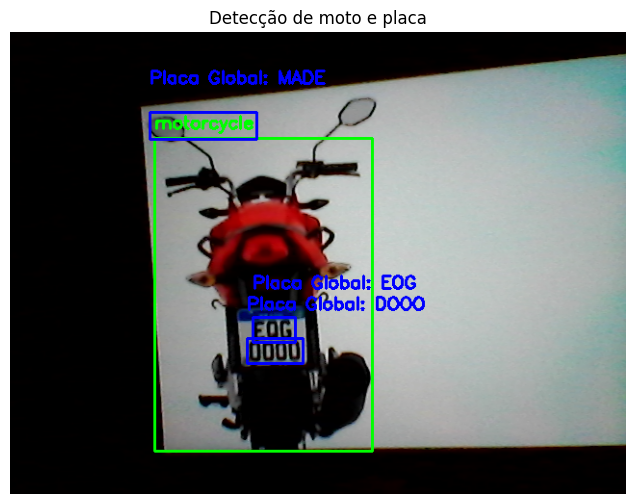

In [41]:
# ========================
# Função para capturar imagem da webcam
# ========================
def capture_from_webcam(filename="captura.png"):
    print("Posicione a placa da moto bem visível e iluminada, a cerca de 10-20 cm da câmera. Aguarde 5 segundos...")
    js = """
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      video.play();

      // Espera 3s para estabilizar a câmera
      await new Promise(resolve => setTimeout(resolve, 5000));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      const dataUrl = canvas.toDataURL('image/png');
      div.remove();
      return dataUrl;
    }
    takePhoto();
    """
    data = output.eval_js(js)
    if data.startswith("data:image/png;base64,"):
        data = data.split(",")[1]
    import base64
    img_bytes = base64.b64decode(data)
    with open(filename, "wb") as f:
        f.write(img_bytes)
    return filename

# ========================
# Detecção de Placa
# ========================
def detectar_placa(img_path):
    # Carregar modelo YOLO para motos
    model_moto = YOLO('yolov8n.pt')

    # Baixar e carregar modelo YOLO para placas
    model_repo = "keremberke/yolov8m-nas-license-plate"
    model_file = "best.pt"
    try:
        model_path = hf_hub_download(repo_id=model_repo, filename=model_file, local_dir="./models")
        model_placa = YOLO(model_path)
        print(f"Modelo de placa carregado de: {model_path}")
    except Exception as e:
        print(f"Erro ao baixar modelo de placa: {e}. Usando fallback OCR global.")
        model_placa = None

    reader = easyocr.Reader(['pt', 'en'], gpu=False)

    img = cv2.imread(img_path)
    if img is None:
        print(f"Erro: Não foi possível carregar a imagem em {img_path}.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # DETECÇÃO DE MOTOS
    results_moto = model_moto(img_rgb, conf=0.4)[0]
    for box in results_moto.boxes:
        cls = int(box.cls[0])
        label = model_moto.names[cls]
        if label not in ['motorbike', 'motorcycle']:
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

    # DETECÇÃO DE PLACAS
    if model_placa:
        results_placa = model_placa(img_rgb, conf=0.15, classes=[0])[0]  # Maior sensibilidade
        if not results_placa.boxes:
            print("Nenhuma placa detectada pelo modelo YOLO.")
        for box in results_placa.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_rgb, f"Placa (conf: {conf:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

            # Crop da placa com margem
            margin = 20
            x1 = max(0, x1 - margin)
            y1 = max(0, y1 - margin)
            x2 = min(img.shape[1], x2 + margin)
            y2 = min(img.shape[0], y2 + margin)
            placa_crop = img[y1:y2, x1:x2]
            if placa_crop.size == 0:
                print(f"Crop inválido em ({x1}, {y1}, {x2}, {y2})")
                continue

            # Pré-processamento avançado
            placa_gray = cv2.cvtColor(placa_crop, cv2.COLOR_BGR2GRAY)
            placa_filt = cv2.bilateralFilter(placa_gray, 9, 75, 75)
            placa_eq = cv2.equalizeHist(placa_filt)
            placa_sharp = cv2.addWeighted(placa_eq, 1.5, placa_filt, -0.5, 0)
            kernel = np.ones((2, 2), np.uint8)
            placa_morph = cv2.morphologyEx(placa_sharp, cv2.MORPH_CLOSE, kernel)  # Remover ruído
            placa_adaptive = cv2.adaptiveThreshold(placa_morph, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, 15, 5)

            # Redimensionar para melhorar o OCR
            placa_resized = cv2.resize(placa_adaptive, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

            # Exibir crop da placa para debug
            plt.figure(figsize=(4, 4))
            plt.imshow(placa_resized, cmap='gray')
            plt.title('Crop da Placa (Debug)')
            plt.axis('off')
            plt.show()

            # OCR
            resultado_ocr = reader.readtext(placa_resized)
            if not resultado_ocr:
                print(f"Nenhum texto detectado na placa em ({x1}, {y1}, {x2}, {y2})")
            for (bbox, text, conf_ocr) in resultado_ocr:
                print(f"OCR detectou: '{text}' (conf: {conf_ocr:.2f})")
                text_clean = re.sub(r'[^A-Z0-9]', '', text.replace(" ", "").replace("-", "").upper())
                if len(text_clean) >= 3:  # Relaxado para capturar mais caracteres
                    if re.match(r"^[A-Z]{3}\d[A-Z0-9]\d{2}$", text_clean):
                        cv2.putText(img_rgb, f"Placa: {text_clean}", (x1, y2 + 20),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
                    else:
                        cv2.putText(img_rgb, f"Texto: {text_clean}", (x1, y2 + 40),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    else:
        # Fallback: OCR global
        print("Usando OCR global como fallback...")
        ocr_globais = reader.readtext(img_rgb)
        if not ocr_globais:
            print("Nenhum texto detectado no OCR global.")
        for (bbox, text, conf) in ocr_globais:
            print(f"OCR global detectou: '{text}' (conf: {conf:.2f})")
            text_clean = re.sub(r'[^A-Z0-9]', '', text.replace(" ", "").replace("-", "").upper())
            if len(text_clean) >= 3:
                (tl, tr, br, bl) = bbox
                tl = tuple(map(int, tl))
                br = tuple(map(int, br))
                if re.match(r"^[A-Z]{3}\d[A-Z0-9]\d{2}$", text_clean):
                    cv2.rectangle(img_rgb, tl, br, (255, 0, 0), 2)
                    cv2.putText(img_rgb, f"Placa Global: {text_clean}", (tl[0], tl[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                else:
                    cv2.rectangle(img_rgb, tl, br, (0, 0, 255), 2)
                    cv2.putText(img_rgb, f"Placa Global: {text_clean}", (tl[0], tl[1] - 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # EXIBIR RESULTADO
    plt.figure(figsize=(12, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Detecção de moto e placa')
    plt.show()

# ========================
# Execução principal
# ========================
if __name__ == "__main__":
    # Capturar imagem da webcam
    img_path = capture_from_webcam("captura_webcam.png")
    print("Imagem capturada:", img_path)

    # Processar para detecção de placa
    print("Processando detecção de placa...")
    detectar_placa(img_path)